In [1]:
import numpy as np
import pandas as pd
import h5py

In [2]:
import flammkuchen as fl

## Documentation for Data from Moseq:


- *syllables_seq_data* that contains a dictionary of data. 

        - dictionary keys are the source filenames for the original DLC data (basically, an experimental session);
        - entries are dictionaries containing various quantities extracted by MPMoseq, including syllable sequence

- *syllableraw_data* contains the raw coordinates for all syllables - aka, what we should be using for soft clustering. 

        - This is actually very row data: (N x T x K x S) arrays, with N=n. of syllables, T= n. of timepoints (20),
        - K= n. of tracked points (11), S=n. of spatial dimensions (2). 
        - What they do for the embedding is simple PCA; if the data is too large, PCs can be computed on a subset of the data


- *index* contains for every element in syllableraw_data.hdf5 the file and the index where the entry in the array occurred

## Approach Without GMM:

In [3]:
syllableraw_data = fl.load('../thomas_data/syllableraw_data.hdf5')
syllables_seq_data = fl.load('../thomas_data/syllables_sequences.hdf5')
index = fl.load('../thomas_data/indexes.hdf5')

In [4]:
frame_syllables = syllables_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']['syllable'] # convert index frames=>index syll

In [10]:
np.diff(frame_syllables) # 

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
example = np.load('../GMM/toy_covars.npy')

example.shape

(7, 2, 2)

In [5]:

def get_array(data_dict):
    pre_pca = {}
    ar = []
    for label, data in data_dict.items():
        n, time_points, tracked_points, spatial_dims = data.shape
        
        # Reshape data to combine time points, tracked points, and spatial dimensions
        reshaped_data = data.reshape(n, time_points * tracked_points * spatial_dims)
        pre_pca[label] = reshaped_data
    return pre_pca

prepca = get_array(syllableraw_data)

In [6]:
from sklearn.decomposition import PCA

combined_data = np.vstack(list(prepca.values()))

pca = PCA(n_components=0.85)

pca.fit(combined_data)

transformed_dict = {key: pca.transform(data) for key, data in prepca.items()}



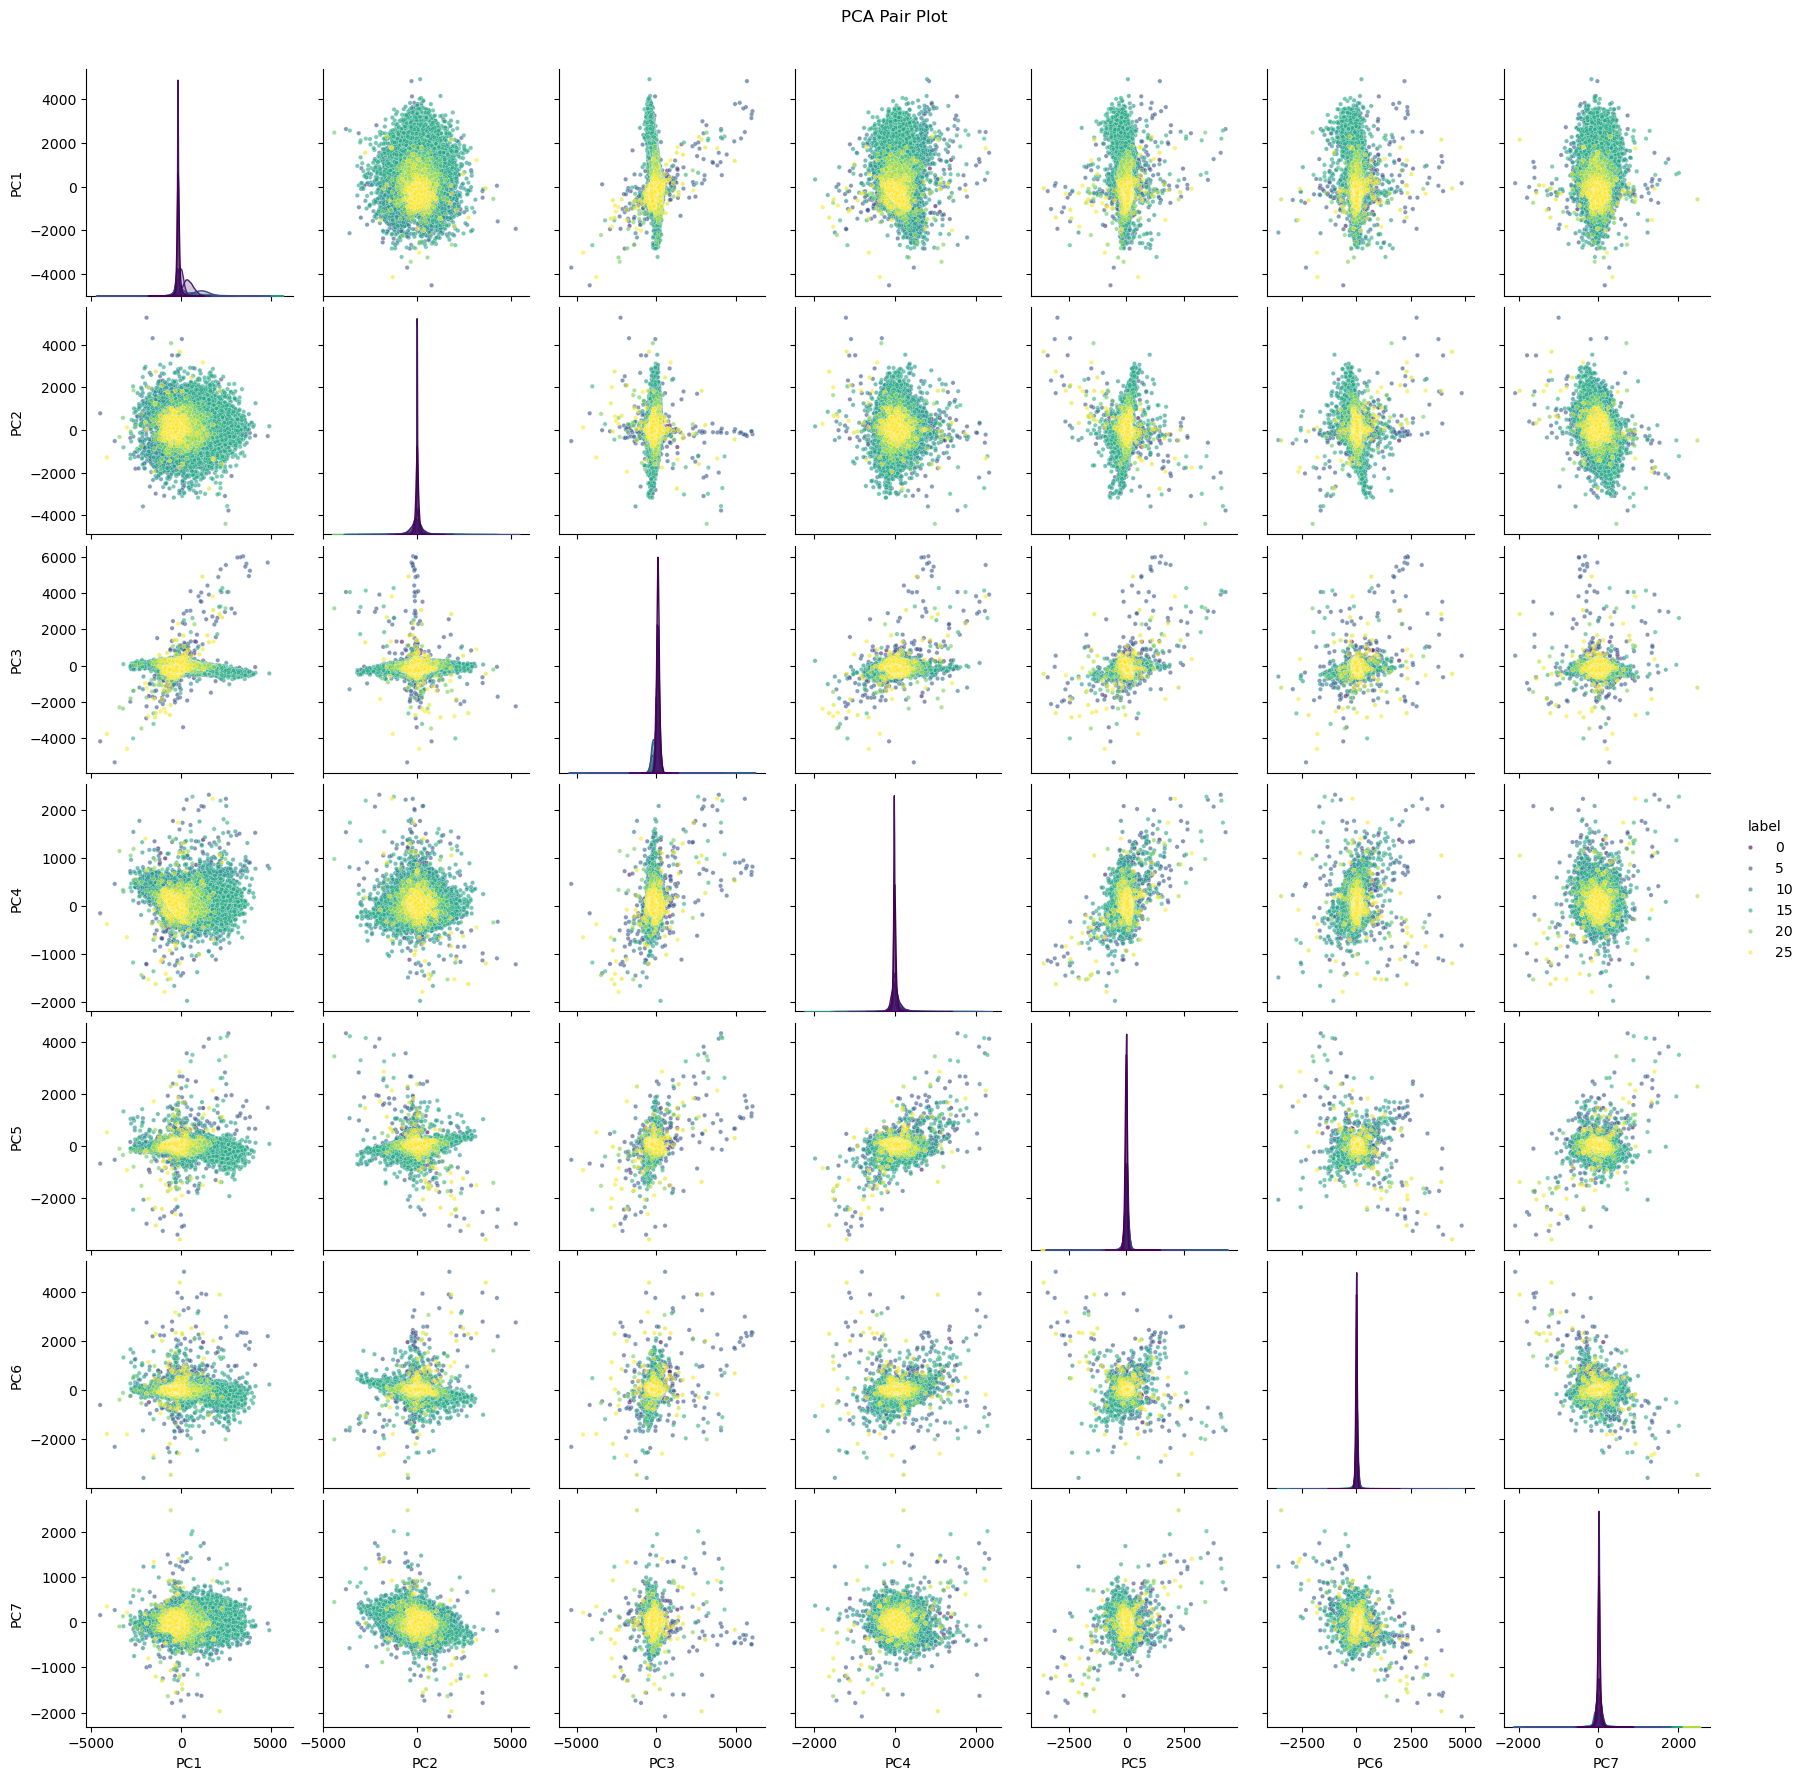

In [9]:
%timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `prepca` is a dictionary with your pre-PCA data.
# combined_data = np.vstack(list(prepca.values()))
# pca = PCA(n_components=0.85)
# pca.fit(combined_data)
# transformed_dict = {key: pca.transform(data) for key, data in prepca.items()}


# Combine the transformed data into a single DataFrame
df_list = []
for key, transformed_data in transformed_dict.items():
    temp_df = pd.DataFrame(transformed_data, columns=[f'PC{i+1}' for i in range(transformed_data.shape[1])])
    temp_df['label'] = key
    df_list.append(temp_df)

df = pd.concat(df_list)

# Plotting the pairplot
sns.pairplot(df, hue='label', palette='viridis', markers='o', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10})

# Customize the plot as per your requirement
plt.suptitle('PCA Pair Plot', y=1.02)
plt.show()


In [14]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [ ]:
import plotly.express as px

def create_scatter_matrix(data_dict):
    for key, data in data_dict.items():
        
        pca = PCA()
        components = pca.fit_transform(data)
        
        
        labels = {
            str(i): f"PC {i+1} ({var:.1f}%)"
            for i, var in enumerate(pca.explained_variance_ratio_ * 100)
        }
        
        # Create scatter plot matrix
        fig = px.scatter_matrix(
            components,
            labels=labels,
            dimensions=range(min(4, components.shape[1])),  # Adjust number of dimensions if PCA components are less than 4
            title=f'Scatter Matrix for {key}'
        )
        fig.update_traces(diagonal_visible=False)
        fig.show()

# Generate scatter plot matrix for each key in the dictionary
create_scatter_matrix(prepca)

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()


pca = PCA(n_components=0.85)
data = scaler.fit_transform(prepca[3])
pca.fit(data)

PCA(n_components=0.85)

In [86]:
n_components = []
for key, value in prepca.items():
    pca = PCA(n_components=14)
    data = scaler.fit_transform(value)
    pca.fit(data)
    n_components.append(pca.explained_variance_ratio_)
    
    


In [104]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def compute_pca_mean_and_covariance(data_dict, n_components=14):
    pca_means = {}
    pca_covariance_matrices = {}
    
    for label, data in data_dict.items():
        # Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(data)
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(standardized_data)
        
        # Compute mean vector on the reduced data
        mean_vector = np.mean(reduced_data, axis=0)
        pca_means[label] = mean_vector
        
        # Compute covariance matrix on the reduced data
        covariance_matrix = np.cov(reduced_data, rowvar=False)
        pca_covariance_matrices[label] = covariance_matrix
    
    return pca_means, pca_covariance_matrices

pca_cov_matrices, pca_means = compute_pca_mean_and_covariance(prepca, n_components=14)


In [105]:
moseq_covs = []
for key, value in pca_cov_matrices.items():
    
    moseq_covs.append(value)
moseq_covs = np.asanyarray(moseq_covs)
moseq_covs.shape

(25, 14)

In [106]:
np.save('../GMM/moseqf0_covars.npy', moseq_covs)

In [108]:
moseq_means = []

for key, value in pca_means.items():
    moseq_means.append(value)
moseq_means = np.asanyarray(moseq_means)

np.save('../GMM/moseqf0_means.npy', moseq_means)

In [44]:
weights = np.load('../GMM/toy_weights.npy')

weights[0].sum() # how to get them: 

1.0000000000000002

In [50]:
exp1 = syllables_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']

In [53]:
len(np.unique(exp1['syllable']))

38

In [52]:
len(syllableraw_data)

25

In [11]:
syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000'].keys()

dict_keys(['centroid', 'heading', 'latent_state', 'syllable', 'type'])

In [14]:
syllables_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']['syllable'].shape

(45588,)

In [33]:
toy_cov = np.load('../GMM/toy_covars.npy')
toy_means = np.load('../GMM/toy_means.npy')
toy_weights = np.load('../GMM/toy_weights.npy')

print(toy_cov.shape)
print(toy_means.shape)
print(toy_weights.shape)

(7, 2, 2)
(7, 2)
(3, 7)


So now we are trying to extract the values directly from mosew without using the GMM model. First I have checked how they are structered and we should obtain a covariance matrix of the following shape: n_labels x dimensions x 2
Then the mean values: n_labels x dimensions
then weigths: ? x lables

Here we construct the training data, from the first experimental condition. We need a npy file of n(data points) x m(features) in this case we are using just the PCAs and not other features. 

In [45]:
condition_key = 'Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000'
condition_data = syllables_seq_data[condition_key]


training_data = []


for entry in condition_data['latent_state']:
    latent_state = entry  
    training_data.append(latent_state)


training_data_array = np.array(training_data)

print("Training data shape:", training_data_array.shape) 

np.save('../Data/train_dataset_condition0.npy', training_data_array)

Training data shape: (45588, 8)


In [49]:
lengths = np.array([45588])
np.save('../Data/train_lengths_condition0.npy', lengths)

With this approach I get the following error: 

(bass-iit-env)  thomasbush@MBP-di-thomas  ~/BASS   master ±  python run_bass.py -c 0 -dN train -gN train -x train
Traceback (most recent call last):
  File "/Users/thomasbush/BASS/run_bass.py", line 100, in <module>
    main(args)
  File "/Users/thomasbush/BASS/run_bass.py", line 50, in main
    H = -model_fit.score(data_flat,args.Condition)/len(data_flat) #entropy
  File "/Users/thomasbush/BASS/./BASS/GMM.py", line 129, in score
    temp += self.weights_[set_index,k]*stats.multivariate_normal.pdf(dataset,mean = self.means_[k],cov = self.covars_[k])
  File "/Users/thomasbush/miniconda3/envs/bass-iit-env/lib/python3.9/site-packages/scipy/stats/_multivariate.py", line 587, in pdf
    out = np.exp(self._logpdf(x, mean, cov_object))
  File "/Users/thomasbush/miniconda3/envs/bass-iit-env/lib/python3.9/site-packages/scipy/stats/_multivariate.py", line 530, in _logpdf
    dev = x - mean
ValueError: operands could not be broadcast together with shapes (45588,8) (440,)

## Data Exploration and Data Used with the GMM (Still messy)

In [52]:
keys_syl = syllableraw_data.keys()
print(keys_syl)

for k, v in syllableraw_data.items():
    print(v.shape)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25])
(19924, 20, 11, 2)
(15815, 20, 11, 2)
(11503, 20, 11, 2)
(10217, 20, 11, 2)
(6635, 20, 11, 2)
(5658, 20, 11, 2)
(2954, 20, 11, 2)
(5819, 20, 11, 2)
(4966, 20, 11, 2)
(4230, 20, 11, 2)
(3682, 20, 11, 2)
(4002, 20, 11, 2)
(4630, 20, 11, 2)
(1904, 20, 11, 2)
(2889, 20, 11, 2)
(3085, 20, 11, 2)
(4115, 20, 11, 2)
(1693, 20, 11, 2)
(1895, 20, 11, 2)
(1585, 20, 11, 2)
(1587, 20, 11, 2)
(1280, 20, 11, 2)
(942, 20, 11, 2)
(1634, 20, 11, 2)
(883, 20, 11, 2)


In [89]:
key_ind = index_data.keys()

index_data[1][0]

('Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000',
 536,
 544)

In [7]:
i = x.keys()
    

In [8]:
x['syllable']

array([21, 21, 21, ...,  0,  0,  0])

In [9]:
for n in i:
    print(x[n].shape)

(45588, 2)
(45588,)
(45588, 8)
(45588,)
()


So in this case we have for the syllable '0': 

- 199924: 
- 20: 
- 11: 
- 2: 

In [10]:
syllable_seq_data['# Example features for condition 0
condition0_features = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']


centroid = condition0_features['centroid']
heading = condition0_features['heading']
latent_state = condition0_features['latent_state']
syllable = condition0_features['syllable']
type_ = condition0_features['type']


condition0_dataset = np.column_stack((centroid, heading, latent_state, syllable))

np.save('moseq_dataset_condition0.npy', condition0_dataset)


condition1_dataset = np.column_stack((centroid, heading, latent_state, syllable)) # Replace with actual condition 1 data


np.save('moseq_dataset_condition1.npy', condition1_dataset)
']['syllable'].shape

(45588,)

In [11]:
index_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25])

So ideally we can use each of these as conditions:

In [19]:
data_try = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']

In [24]:
for key, value in data_try.items():
    print(value.shape) # so we can see that for each syllable we have specific values for latent states, direction and positionb

(45588, 2)
(45588,)
(45588, 8)
(45588,)
()


In [13]:
data_toy = np.load('/Users/thomasbush/BASS/Data/toy_dataset_condition0.npy')

In [14]:
data_toy.shape

(5000, 2)

In [15]:
import matplotlib.pyplot as plt

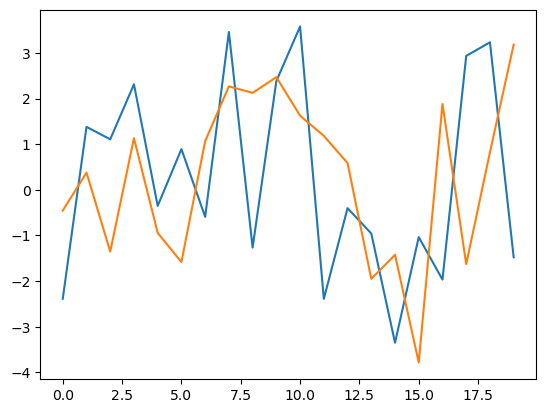

In [16]:
plt.figure()

plt.plot(data_toy[:20])

plt.show()

## Approach to preprare the data:

In [56]:



condition0_features = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']

centroid = condition0_features['centroid']
heading = condition0_features['heading']
latent_state = condition0_features['latent_state']
syllable = condition0_features['syllable']
type_ = condition0_features['type']

condition0_dataset = np.column_stack((centroid, heading, latent_state, syllable))


np.save('moseq_dataset_condition0.npy', condition0_dataset)

condition1_dataset = np.column_stack((centroid, heading, latent_state, syllable)) 

np.save('moseq_dataset_condition1.npy', condition1_dataset)


In [57]:
moseq_d = np.load('moseq_dataset_condition1.npy')

In [105]:
cov = np.load('../GMM/toy_covars.npy')
mean = np.load('../GMM/toy_means.npy')
weights = np.load('../GMM/toy_weights.npy')

toy = np.load('../Data/toy_dataset_condition0.npy')
res = pd.read_csv('../Results/toy/toy_condition_0/BASS_dictionary.csv')
comp = pd.read_csv('../Results/toy/toy_condition_0/Comparison_to_HMM.csv')

In [106]:
weights.shape

(3, 7)

In [76]:
res

,Probability,Number of occurences,Sequences
0,0.186862,934,['5']
1,0.180705,903,['1']
2,0.144951,724,['2']
3,0.138395,691,['4']
4,0.135178,675,['7']
5,0.121369,606,['6']
6,0.092539,462,['3']


In [77]:
comp

,Negative log P values,Empirical frequency,Expected frequency,Motif
0,0.070999,0.172967,0.171951,['1']
1,0.022201,0.172013,0.171680,['5']
2,0.013039,0.139655,0.139473,['2']
3,0.008101,0.122286,0.122178,['6']
4,0.006405,0.139339,0.139249,['4']


In [79]:
toy.shape

(5000, 2)

### Condition one:

In [80]:
cond_data1 = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']

In [81]:
cond_data1

{'centroid': array([[220.7422596 , 981.41291399],
        [222.34605388, 980.60392267],
        [224.54893412, 981.63115063],
        ...,
        [116.87169827, 147.17285453],
        [116.12545226, 148.82934934],
        [115.91010344, 150.40723622]]),
 'heading': array([0.39192024, 0.47737155, 0.67489787, ..., 0.7841658 , 0.77901342,
        0.84501413]),
 'latent_state': array([[-1.19241833,  1.35717169,  2.65219351, ...,  0.37310682,
          3.21341644,  0.93361785],
        [-0.77525371, -0.28492257, -0.72993807, ...,  1.69601123,
          0.55539169, -0.85027704],
        [ 0.596823  , -2.13652034, -0.33890765, ...,  0.14232277,
         -0.70521653, -0.67117819],
        ...,
        [ 0.20445175, -0.58423915,  0.12254727, ...,  1.51520007,
         -1.14741272, -0.23531692],
        [ 0.29240208, -0.50973049,  0.22232672, ...,  1.48763074,
         -1.06110249, -0.59077329],
        [ 0.29159247, -0.42689718,  0.28574157, ...,  1.45309226,
         -0.58323332, -0.92854756]

In [98]:
condition_lengths = []


for syllable_key, indices in index_data.items():
    for entry in indices:
        file, start, end = entry
        if file == 'Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000':
            length = end - start + 1
            condition_lengths.append(length)


np.save('moseq_lengths_condition0.npy', condition_lengths)


print("Condition lengths:", condition_lengths)


Condition lengths: [30, 37, 5, 13, 20, 22, 11, 58, 14, 24, 14, 14, 7, 32, 36, 49, 16, 37, 19, 17, 28, 9, 6, 32, 21, 96, 42, 11, 25, 14, 12, 22, 12, 64, 31, 22, 33, 59, 5, 16, 25, 13, 36, 24, 11, 8, 25, 34, 17, 9, 28, 23, 22, 8, 8, 20, 18, 11, 12, 52, 25, 9, 73, 49, 49, 16, 9, 10, 18, 10, 46, 25, 31, 13, 38, 19, 15, 12, 19, 47, 34, 119, 23, 28, 53, 44, 17, 14, 10, 8, 13, 20, 10, 11, 13, 44, 73, 9, 43, 215, 8, 40, 110, 14, 49, 15, 11, 4, 4, 14, 6, 12, 12, 26, 19, 49, 13, 48, 54, 21, 21, 8, 22, 36, 8, 13, 22, 4, 23, 6, 19, 6, 9, 16, 8, 9, 25, 24, 15, 37, 31, 15, 32, 22, 12, 45, 33, 22, 25, 23, 16, 8, 48, 24, 13, 22, 23, 40, 21, 22, 25, 17, 29, 13, 8, 5, 5, 17, 29, 9, 50, 16, 36, 15, 59, 33, 11, 11, 23, 28, 55, 29, 37, 17, 24, 25, 20, 18, 48, 15, 51, 42, 40, 21, 25, 12, 15, 71, 70, 65, 17, 44, 44, 40, 19, 22, 62, 5, 16, 8, 28, 20, 28, 42, 38, 48, 63, 26, 47, 18, 16, 53, 47, 12, 19, 16, 12, 5, 12, 32, 151, 24, 15, 40, 24, 28, 25, 12, 83, 55, 64, 27, 14, 27, 23, 50, 35, 20, 12, 28, 18, 48, 3

In [47]:

labels = syllableraw_data.keys()
keys = np.unique(labels)


keys_str = ','.join(map(str, keys))


with open('../Data/train_class_names.txt', 'w') as f:
    f.write(keys_str)

print("Keys have been written to moseq_class_names.txt")

Keys have been written to moseq_class_names.txt


In [ ]:
lengths = np.array([])

In [107]:
from sklearn.mixture import GaussianMixture


num_syllables = len(syllableraw_data)
covariances = []
means = []
weights = []

for syllable, data in syllableraw_data.items():
    N, T, K, S = data.shape
    flattened_data = data.reshape(N, T * K * S)
    
    gmm = GaussianMixture(n_components=1, covariance_type='full')
    gmm.fit(flattened_data)
    
    covariances.append(gmm.covariances_[0])
    means.append(gmm.means_[0])
    weights.append(gmm.weights_[0])

covariances = np.array(covariances)
means = np.array(means)
weights = np.array(weights).reshape(1, -1)  



print("Covariances shape:", covariances.shape)
print("Means shape:", means.shape)
print("Weights shape:", weights.shape)


Covariances shape: (25, 440, 440)
Means shape: (25, 440)
Weights shape: (1, 25)


In [108]:

np.save('moseq_weights.npy', weights)

In [109]:
for syllable_key, indices in index_data.items():
    for entry in indices:
        file, start, end = entry
        if file == 'Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000':
            length = end - start + 1
            condition_lengths.append(length)

total_length = sum(condition_lengths)
print(f"Total length of segments: {total_length}")


np.save('phtaxis_lengths_condition0.npy', condition_lengths)

print("Condition lengths:", condition_lengths)

Total length of segments: 92260
Condition lengths: [30, 37, 5, 13, 20, 22, 11, 58, 14, 24, 14, 14, 7, 32, 36, 49, 16, 37, 19, 17, 28, 9, 6, 32, 21, 96, 42, 11, 25, 14, 12, 22, 12, 64, 31, 22, 33, 59, 5, 16, 25, 13, 36, 24, 11, 8, 25, 34, 17, 9, 28, 23, 22, 8, 8, 20, 18, 11, 12, 52, 25, 9, 73, 49, 49, 16, 9, 10, 18, 10, 46, 25, 31, 13, 38, 19, 15, 12, 19, 47, 34, 119, 23, 28, 53, 44, 17, 14, 10, 8, 13, 20, 10, 11, 13, 44, 73, 9, 43, 215, 8, 40, 110, 14, 49, 15, 11, 4, 4, 14, 6, 12, 12, 26, 19, 49, 13, 48, 54, 21, 21, 8, 22, 36, 8, 13, 22, 4, 23, 6, 19, 6, 9, 16, 8, 9, 25, 24, 15, 37, 31, 15, 32, 22, 12, 45, 33, 22, 25, 23, 16, 8, 48, 24, 13, 22, 23, 40, 21, 22, 25, 17, 29, 13, 8, 5, 5, 17, 29, 9, 50, 16, 36, 15, 59, 33, 11, 11, 23, 28, 55, 29, 37, 17, 24, 25, 20, 18, 48, 15, 51, 42, 40, 21, 25, 12, 15, 71, 70, 65, 17, 44, 44, 40, 19, 22, 62, 5, 16, 8, 28, 20, 28, 42, 38, 48, 63, 26, 47, 18, 16, 53, 47, 12, 19, 16, 12, 5, 12, 32, 151, 24, 15, 40, 24, 28, 25, 12, 83, 55, 64, 27, 14, 27, 2

## Bug Fixing

In [121]:
data = np.load('../Data/moseq_dataset_condition0.npy')

In [122]:
data.shape

(45588, 12)

In [123]:
moseq1 = data[:10000, :]

In [124]:
moseq1.shape

(10000, 12)

In [126]:
np.save('moseq1_dataset_condition0.npy', moseq1)

92260

In [139]:
moseq1s_lengths = np.array([1250, 1250, 1250, 1250])

In [140]:
np.save('moseq1_lengths_condition0.npy', moseq1s_lengths)

In [135]:
leng = np.load('../Data/toy_lengths_condition0.npy')

In [136]:
leng # test lengths for BASS model: get how to divide them from moseq.

array([1250, 1250, 1250, 1250])

In [141]:
sul = np.load('../GMM/moseq_covars.npy')

In [142]:
sul.shape

(26, 12, 12)

## Next Steps:


Command to run BASS: it requires to specify:

- Condition
- Dataset name
- GMM model name

Let's analyse their toy data to see how we need to change our data


### Toy Data + Condition

In [1]:
toy_data = np.load('../Data/toy_dataset_condition0.npy')
print(toy_data.shape)# n=5k, features = 2

(5000, 2)


In [3]:
toy_lengths = np.load('../Data/toy_lengths_condition0.npy')
print(toy_lengths.shape)
print(toy_lengths)# the data has been divided in 4 perfect lengths

(4,)
[1250 1250 1250 1250]


In [4]:
toy_names = open('../Data/toy_class_names.txt')
print(toy_names.read())# 7 classes names

1,2,3,4,5,6,7



### Toy GMM

In [5]:
toy_cov = np.load('../GMM/toy_covars.npy')
toy_mean = np.load('../GMM/toy_means.npy')
toy_w = np.load('../GMM/toy_weights.npy')

In [6]:
print(toy_cov.shape) # each classes has a douple value for each one 
print(toy_mean.shape) # mean for each classes and feature
print(toy_w.shape) # 

(7, 2, 2)
(7, 2)
(3, 7)


What else are we missing?

### Create the Data:

In [9]:
moseq_data_0 = np.load('../Data/moseq1_dataset_condition0.npy')
print(moseq_data_0.shape) # n=10k, features = 12

(10000, 12)


In [18]:
# divide the lengths as with the toy data in 4?
moseq_len = np.load('../Data/moseq1_lengths_condition0.npy')
print(moseq_len.shape)
print(moseq_len)
moseq_len = np.array([2500, 2500, 2500, 2500])
np.save('../Data/moseq1_lengths_condition0.npy', moseq_len)

(4,)
[1250 1250 1250 1250]


Now, we need to obtain the covariance, means and weigths for each of the classes (which are the syllabels), how to do that? first we should explore the class names:


In [19]:
moseq_names = open('../Data/moseq1_class_names.txt')
print(moseq_names.read())# we do have 25 classes in our case, as we don't have the 17 (?)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25


Now, we can start by running their GMM model to see how it works in this case:

In [20]:
moseq1_cov = np.load('../GMM/moseq1_covars.npy')
moseq1_mean = np.load('../GMM/moseq1_means.npy')
moseq1_w = np.load('../GMM/moseq1_weights.npy')

In [22]:
print(moseq1_cov.shape)
print(moseq1_mean.shape)
print(moseq1_w.shape)

(25, 12, 12)
(25, 12)
(1, 25)


Now we can analyse quickly how they look by using their notebook:

In [25]:
# now we create a subset for BASS that is like .02 of the whole data so 2k
moseq1s = moseq_data_0[:2000]
np.save('../Data/moseq1s_dataset_condition0.npy', moseq1s)

In [ ]:
moseq1s_len = np.array([1250, 1250, 1250, 1250])

In [29]:
words = np.load('../Results/moseq1/moseq1s_condition_0_seg_bouttypes.npy')

In [30]:
words

array([24, 14, 14, ...,  6,  6,  6])

### get GMM data from moseq:

In [49]:
moseq_data_0.shape

(10000, 12)

In [51]:
syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000'].keys()

dict_keys(['centroid', 'heading', 'latent_state', 'syllable', 'type'])

In [58]:
cent = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']['centroid']
head = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']['heading']
pcas = syllable_seq_data['Ctrl1_d1DLC_resnet50_r2_below-camera_paws-spineFeb2shuffle1_100000']['latent_state']
print(cent.shape, head.shape, pcas.shape)

(45588, 2) (45588,) (45588, 8)


In [73]:
array2_reshaped = np.expand_dims(head, axis=1)

# Concatenate along the second axis
combined_array = np.concatenate((cent, array2_reshaped, pcas), axis=1)

In [74]:
np.save('../Data/moseq2s_dataset_condition0.npy', combined_array)

In [75]:
lens = np.array([45588])
np.save('../Data/moseq2s_lengths_condition0.npy', lens)

In [68]:
unique_labels = np.unique(labels)
unique_labels.shape

(38,)

In [86]:
combined_array.shape

(45588, 11)

In [90]:



data =  combined_array



features = combined_array
labels = labels

unique_labels = np.unique(labels)

means = np.zeros((len(unique_labels), features.shape[1]))
covariances = np.zeros((len(unique_labels), features.shape[1], features.shape[1]))
weights = np.zeros(len(unique_labels))

for i, label in enumerate(unique_labels):
    
    label_data = features[labels == label]
    
    
    mean = np.mean(label_data, axis=0)
    means[i, :] = mean
    
    
    covariance = np.cov(label_data, rowvar=False)
    covariances[i, :, :] = covariance
    
    
    weight = label_data.shape[0] / features.shape[0]
    weights[i] = weight

weights = weights.reshape(1, -1)


print(means.shape, covariances.shape, weights.shape)
print("Means:\n", means)

print("Covariances:\n", covariances)
print("Weights:\n", weights)


(38, 11) (38, 11, 11) (1, 38)
Means:
 [[ 2.04449170e+02  1.75006808e+02  1.07704452e+00  5.31624908e-01
   1.30619417e-01  3.32989168e-02 -5.21700828e-02 -1.31107547e-01
  -1.06264372e-02 -3.65930594e-01  2.93007210e-02]
 [ 1.84289697e+02  1.11457549e+02  1.19983063e+00  2.84473325e-01
   1.31963257e-01  1.76550594e-01 -1.74783802e-01 -3.39604466e-01
   2.49612967e-01 -4.90555068e-01 -7.85205261e-02]
 [ 1.97852107e+02  4.27153448e+02  5.80839562e-01  1.34630738e+00
   2.89379398e-01 -6.29004119e-02  2.15271004e-01  2.12869835e-01
  -3.35121210e-01  1.43426151e-01 -8.97252996e-02]
 [ 2.57035022e+02  2.73084295e+02  9.90070262e-01  1.07756981e+00
   2.29383156e-02  8.55551495e-03  5.20415091e-02  1.18272997e-01
  -2.38953701e-01 -1.80488347e-01 -6.82127356e-02]
 [ 2.17729622e+02  2.51584268e+02  6.37070482e-01  2.49335810e-01
   9.40420941e-01  3.58448485e-03  1.50466877e-01 -2.29525970e-01
   5.92044435e-02  1.96274558e-02 -4.07419295e-01]
 [ 2.59696370e+02  3.48455090e+02  2.52612096e-

In [99]:



data = combined_array  


features = data


unique_labels = np.unique(labels)

means = np.zeros((len(unique_labels), features.shape[1]))
covariances = np.zeros((len(unique_labels), features.shape[1], features.shape[1]))
weights = np.zeros(len(unique_labels))


epsilon = 1e-6

for i, label in enumerate(unique_labels):

    label_data = features[labels == label]
    

    mean = np.mean(label_data, axis=0)
    means[i, :] = mean
    

    if label_data.shape[0] > 1:
        covariance = np.cov(label_data, rowvar=False)
    else:
       
        covariance = np.outer(label_data, label_data)

    if covariance.ndim == 0:
        covariance = np.array([[covariance]])
    elif covariance.ndim == 1:
        covariance = np.diag(covariance)
    

    covariance += epsilon * np.eye(covariance.shape[0])
    
    covariances[i, :, :] = covariance
    

    weight = label_data.shape[0] / features.shape[0]
    weights[i] = weight


weights = weights.reshape(1, -1)

# Print results
print("Means:\n", means)
print("Covariances:\n", covariances)
print("Weights:\n", weights)


Means:
 [[ 2.04449170e+02  1.75006808e+02  1.07704452e+00  5.31624908e-01
   1.30619417e-01  3.32989168e-02 -5.21700828e-02 -1.31107547e-01
  -1.06264372e-02 -3.65930594e-01  2.93007210e-02]
 [ 1.84289697e+02  1.11457549e+02  1.19983063e+00  2.84473325e-01
   1.31963257e-01  1.76550594e-01 -1.74783802e-01 -3.39604466e-01
   2.49612967e-01 -4.90555068e-01 -7.85205261e-02]
 [ 1.97852107e+02  4.27153448e+02  5.80839562e-01  1.34630738e+00
   2.89379398e-01 -6.29004119e-02  2.15271004e-01  2.12869835e-01
  -3.35121210e-01  1.43426151e-01 -8.97252996e-02]
 [ 2.57035022e+02  2.73084295e+02  9.90070262e-01  1.07756981e+00
   2.29383156e-02  8.55551495e-03  5.20415091e-02  1.18272997e-01
  -2.38953701e-01 -1.80488347e-01 -6.82127356e-02]
 [ 2.17729622e+02  2.51584268e+02  6.37070482e-01  2.49335810e-01
   9.40420941e-01  3.58448485e-03  1.50466877e-01 -2.29525970e-01
   5.92044435e-02  1.96274558e-02 -4.07419295e-01]
 [ 2.59696370e+02  3.48455090e+02  2.52612096e-01  1.11696509e+00
   3.143307

In [100]:
np.save('../GMM/moseq2s_means.npy', means)
np.save('../GMM/moseq2s_covars.npy', covariances)
np.save('../GMM/moseq2s_weights.npy', weights)

In [94]:
covariances[0].shape

(11, 11)

In [83]:
ww = np.load('../GMM/moseq2s_weights.npy')

In [84]:
ww.shape

(1, 38)

In [2]:
seg_word = np.load('../Results/moseq1/moseq1s_condition_0_seg_words.npy')

In [3]:
seg_word

array([54, 26, 10, ...,  8,  8,  8])

In [4]:
x = np.load('../Data/moseq1s_dataset_condition0.npy')

In [5]:
x.shape

(2000, 12)

### Things to do:


- Write to Luigi about: position as data for GMM, GMM on multiple condictions (on teams)
- Train model on Syllables rather than GMM
- Polish notebook and upload it on git
- Write to them to ask for clarification about the model and maybe a meeting
- Study model for better implementation 


In [7]:
import pandas as pd

In [8]:
dicts = pd.read_csv('../Results/moseq1/moseq1s_condition_0/BASS_dictionary.csv')

In [9]:
dicts

,Probability,Number of occurrences,Sequences
0,0.097915,113,"['22', '22', '22', '22', '22', '22', '22', '22..."
1,0.056044,65,"['12', '12', '12', '12', '12', '12', '12', '12..."
2,0.053957,62,"['4', '4', '4', '4', '4', '4', '4', '4', '4', ..."
3,0.041220,47,"['20', '20', '20', '20', '20', '20', '20', '20..."
4,0.037821,44,"['13', '13', '13', '13', '13', '13', '13', '13..."
5,0.037432,43,"['24', '24', '24', '24', '24', '24', '24', '24..."
6,0.037197,43,"['22', '22', '22', '22']"
7,0.032778,38,"['22', '22', '22', '22', '22', '22', '22', '22..."
8,0.030427,35,"['6', '6', '6', '6', '6', '6', '6', '6', '6', ..."
9,0.026989,31,"['0', '0', '0', '0', '0', '0', '0', '0', '0', ..."
